# Analysis of Auction mechanisms

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
folder = '../data/auctions'
for filename in os.listdir(folder):
    if 'auction' in filename:
        with open(f'{folder}/{filename}') as file:
            json_data = json.load(file)
            print(f'{filename}: {len(json_data)}')

auctions_paper_r_t15_s3_dt07-22_11-55-31.json: 50
auctions_paper_r_t30_s6_dt07-22_11-55-31.json: 50
auctions_paper_r_t30_s6_dt07-28_23-48-03.json: 50
auctions_paper_r_t40_s8_dt07-22_11-57-21.json: 45


In [3]:
results_filename = f'{folder}/auctions_paper_r_t15_s3_dt07-22_11-55-31.json'

with open(results_filename) as file:
    results_data = json.load(file)
    
results_data[0].keys()

dict_keys(['model', 'Flexible VCG', 'Fixed VCG', 'Optimal DIA', 'Critical Value Auction Utility / Sqrt Sum, Sum, Percent Sum', 'Critical Value Auction Utility / Sqrt Sum, Sum, Pow percent sum', 'Critical Value Auction Utility / Sqrt Sum, Product, Percent Sum', 'Critical Value Auction Utility / Sqrt Sum, Product, Pow percent sum', 'Critical Value Auction Utility / Sqrt Sum, Random, Percent Sum', 'Critical Value Auction Utility / Sqrt Sum, Random, Pow percent sum', 'Critical Value Auction Utility * deadline / Sum, Sum, Percent Sum', 'Critical Value Auction Utility * deadline / Sum, Sum, Pow percent sum', 'Critical Value Auction Utility * deadline / Sum, Product, Percent Sum', 'Critical Value Auction Utility * deadline / Sum, Product, Pow percent sum', 'Critical Value Auction Utility * deadline / Sum, Random, Percent Sum', 'Critical Value Auction Utility * deadline / Sum, Random, Pow percent sum', 'Critical Value Auction Utility * deadline / Sqrt Sum, Sum, Percent Sum', 'Critical Value Au

In [4]:
auction_results = {}
for model_results in results_data:
    for auction, auction_result in model_results.items():
        if auction == 'model':
            continue
        if auction in auction_results:
            auction_results[auction].append(auction_result)
        else:
            auction_results[auction] = [auction_result]
            
print(f'Number of algorithms: {len(auction_results)}')

Number of algorithms: 21


## Auction results

In [5]:
auction_avg_results = []
for algorithm, results in auction_results.items():
    auction_avg_results.append([
        algorithm,
        [r['social welfare'] for r in results],
        [r['social welfare percent'] for r in results],
        [r['percentage tasks allocated'] for r in results],
        [r['total revenue'] for r in results],
        [r['solve time'] for r in results],
        [task_price for r in results for task_price in r['task prices'].values()],
        np.mean([r['social welfare'] for r in results]),
        np.mean([r['total revenue'] for r in results])        
    ])
    
auction_df = pd.DataFrame(auction_avg_results, columns=[
    'name', 'social welfare', 'social welfare percent', 'percentage tasks allocated', 'revenue', 
    'solve time', 'task prices', 'avg social welfare', 'avg revenue'])
auction_df = auction_df.sort_values(by='avg social welfare', ascending=False)

In [6]:
cva_algos_df = auction_df[auction_df['name'].str.contains('Critical Value Auction')]
cva_algo = auction_df.iloc[cva_algos_df['avg social welfare'].idxmax()]['name']

Text(0.5, 1.0, 'Solve Time')

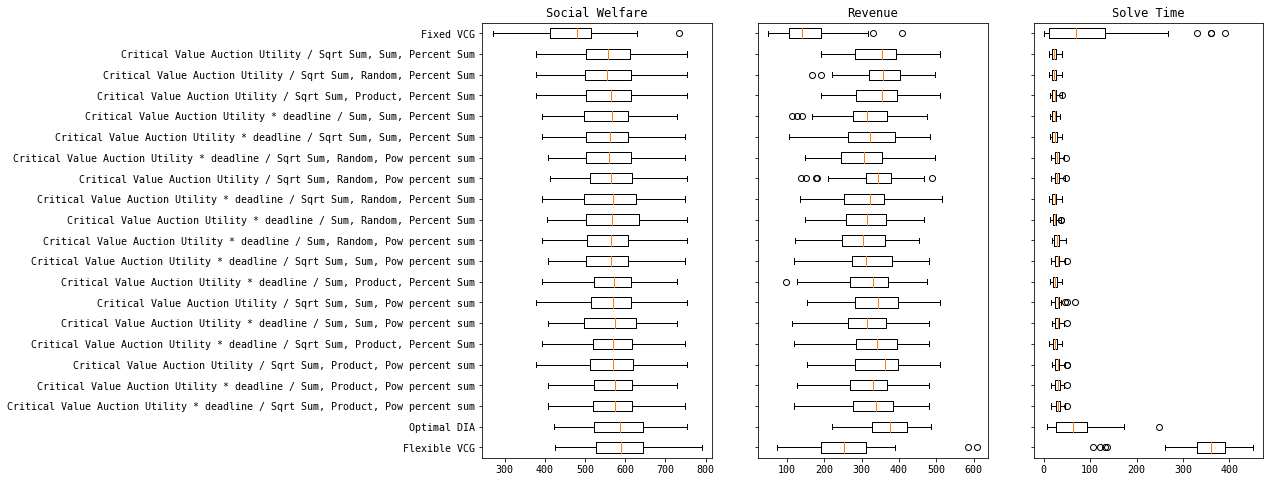

In [7]:
system_fig, (ax_sw, ax_rev, ax_st) = plt.subplots(1, 3, figsize=(14,8))
ax_sw.boxplot(auction_df['social welfare'], vert=False)
ax_sw.set_yticklabels(auction_df['name'])
ax_sw.set_title('Social Welfare')

ax_rev.boxplot(auction_df['revenue'], vert=False)
plt.setp(ax_rev.get_yticklabels(), visible=False)
ax_rev.set_title('Revenue')

ax_st.boxplot(auction_df['solve time'], vert=False)
plt.setp(ax_st.get_yticklabels(), visible=False)
ax_st.set_title('Solve Time')

## Algorithm Task Prices

Text(0.5, 1.0, 'Task Price Distribution')

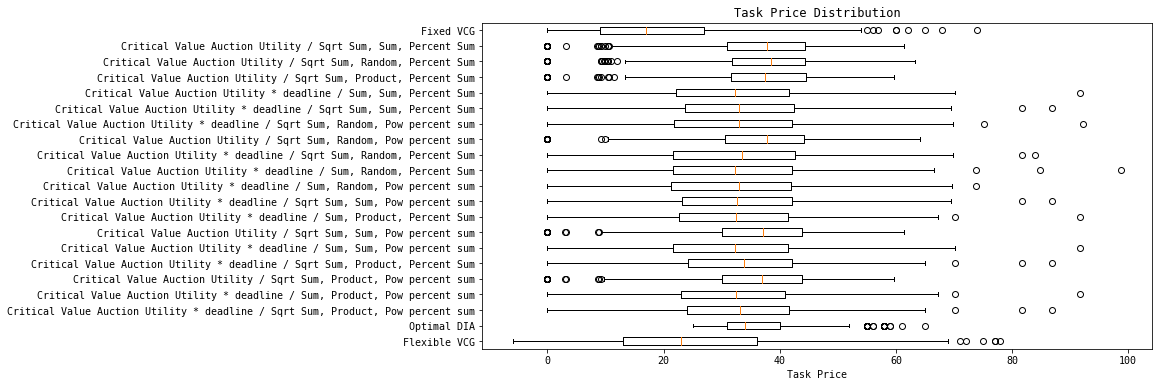

In [8]:
task_price_box_fig, ax_box = plt.subplots(figsize=(12, 6))
ax_box.boxplot(auction_df['task prices'], vert=False)
ax_box.set_yticklabels(auction_df['name'])
ax_box.set_xlabel('Task Price')
ax_box.set_title('Task Price Distribution')

## Task value and price distributions

Text(0.5, 1.0, 'CVA Task Price Distribution')

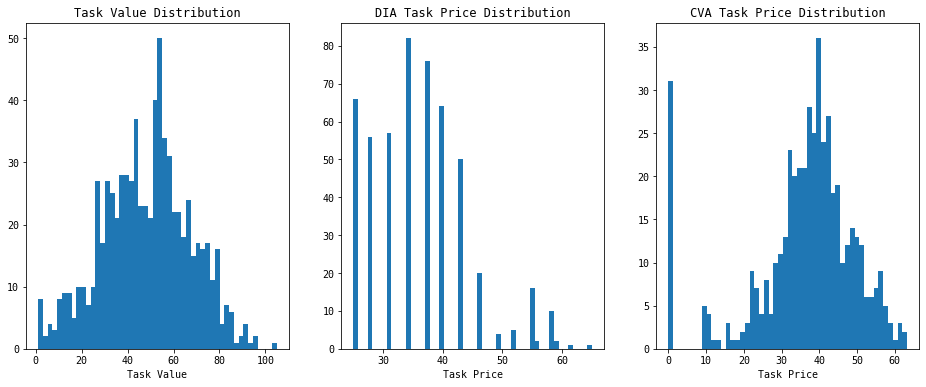

In [9]:
task_price_box_fig, (ax_value_hist, ax_dia_hist, ax_cva_dist) = plt.subplots(1, 3, figsize=(16, 6))

task_values = [task['value'] for result in results_data for task in result['model']['tasks']]
ax_value_hist.hist(task_values, bins=50)
ax_value_hist.set_xlabel('Task Value')
ax_value_hist.set_title('Task Value Distribution')

ax_dia_hist.hist(auction_df[auction_df['name'] == 'Optimal DIA']['task prices'], bins=50)
ax_dia_hist.set_xlabel('Task Price')
ax_dia_hist.set_title('DIA Task Price Distribution')

ax_cva_dist.hist(auction_df[auction_df['name'] == cva_algo]['task prices'], bins=50)
ax_cva_dist.set_xlabel('Task Price')
ax_cva_dist.set_title('CVA Task Price Distribution')

## DIA vs CVA Price difference

Text(0.5, 1.0, 'CVA Value - Price Difference')

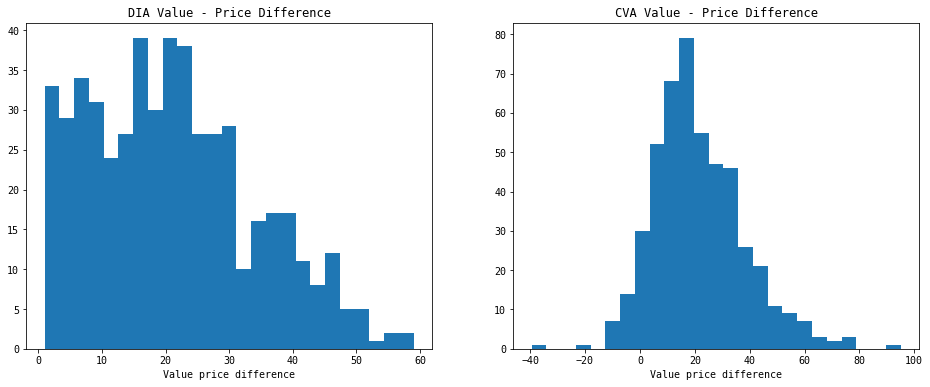

In [10]:
price_diff_fig, (ax_dia_diff, ax_cva_diff) = plt.subplots(1, 2, figsize=(16, 6))

dia_diff = [task['value'] - result['Optimal DIA']['task prices'][task['name']] 
            for result in results_data for task in result['model']['tasks']
            if task['name'] in result['Optimal DIA']['task prices']]
ax_dia_diff.hist(dia_diff, bins=25)
ax_dia_diff.set_xlabel('Value price difference')
ax_dia_diff.set_title('DIA Value - Price Difference')

cva_diff = [task['value'] - result[cva_algo]['task prices'][task['name']] 
            for result in results_data for task in result['model']['tasks']
            if task['name'] in result[cva_algo]['task prices']]
ax_cva_diff.hist(cva_diff, bins=25)
ax_cva_diff.set_xlabel('Value price difference')
ax_cva_diff.set_title('CVA Value - Price Difference')

### Dia comparison

Price change: dict_values([3, 3, 3]), initial price: dict_values([25, 25, 25])


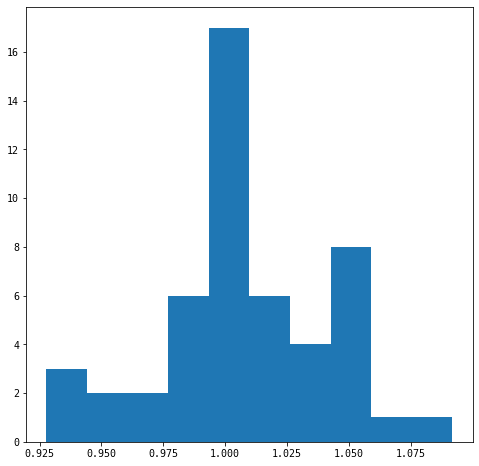

In [11]:
social_welfare_diff = [
    result['Flexible VCG']['social welfare'] / result['Optimal DIA']['social welfare']
    for result in results_data
]

_, ax = plt.subplots(figsize=(8, 8))
ax.hist(social_welfare_diff)

print(f'Price change: {results_data[0]["Optimal DIA"]["server price change"].values()}, '
      f'initial price: {results_data[0]["Optimal DIA"]["server initial price"].values()}')

Text(0, 0.5, 'Value')

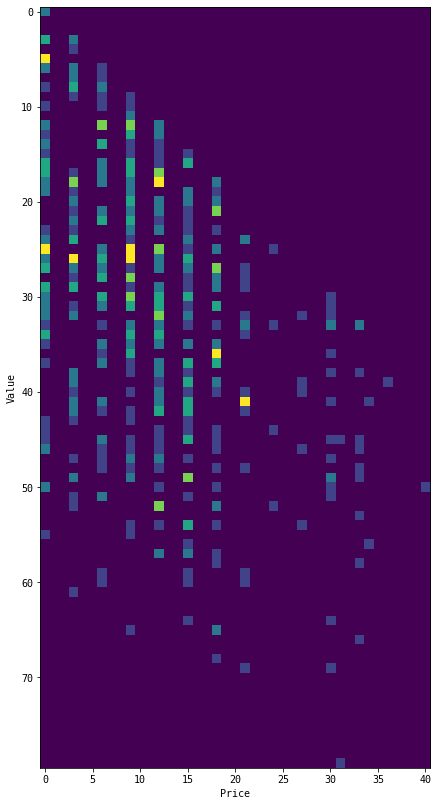

In [12]:
task_value_price = [(task['value'], result['Optimal DIA']['task prices'][task['name']])
                    for result in results_data for task in result['model']['tasks']
                    if task['name'] in result['Optimal DIA']['task prices']]
min_value, max_value = min(value for value, _ in task_value_price), max(value for value, _ in task_value_price)
min_price, max_price = min(price for _, price in task_value_price), max(price for _, price in task_value_price)

_, ax = plt.subplots(figsize=(12, 14))
density = [[task_value_price.count((value, price)) for price in range(min_price, max_price+1)] 
            for value in range(min_value, max_value+1)]
assert sum(sum(d) for d in density) == len(task_value_price), f'{sum(sum(d) for d in density)} {len(task_value_price)}'
ax.imshow(density)
    
ax.set_xlabel('Price')
ax.set_ylabel('Value')

## Overall results

In [13]:
reduced_df = auction_df[(auction_df['name'] == cva_algo) | (auction_df['name'] == 'Flexible VCG') | 
                        (auction_df['name'] == 'Fixed VCG') | (auction_df['name'] == 'Optimal DIA')]
reduced_df = reduced_df.copy()
reduced_df.loc[auction_df['name'] == cva_algo, 'name'] = 'Decentralised Iterative Auction'
reduced_df.loc[auction_df['name'] == 'Optimal DIA', 'name'] = 'Critical Value Auction'
reduced_df

,name,social welfare,social welfare percent,percentage tasks allocated,revenue,solve time,task prices,avg social welfare,avg revenue
0,Flexible VCG,"[481, 522, 690, 575, 444, 584, 643, 589, 631, ...","[0.678, 0.811, 0.877, 0.754, 0.713, 0.896, 0.7...","[0.533, 0.733, 0.8, 0.6, 0.6, 0.733, 0.667, 0....","[103, 250, 322, 192, 163, 301, 302, 253, 248, ...","[270.313, 360.415, 390.452, 300.378, 300.346, ...","[12, 10, 17, 16, 2, 4, 26, 16, 54, 8, 43, 38, ...",590.06,265.20000
2,Critical Value Auction,"[501, 556, 690, 575, 446, 553, 622, 578, 578, ...","[0.707, 0.863, 0.877, 0.754, 0.716, 0.848, 0.6...","[0.533, 0.8, 0.8, 0.6, 0.533, 0.667, 0.6, 0.73...","[401, 375, 432, 388, 296, 346, 486, 365, 450, ...","[167.242, 52.046, 83.498, 68.426, 33.246, 29.6...","[58, 58, 37, 40, 43, 55, 55, 55, 31, 31, 31, 3...",585.22,369.74000
7,Decentralised Iterative Auction,"[464, 488, 648, 522, 428, 517, 618, 551, 578, ...","[0.654, 0.758, 0.823, 0.684, 0.687, 0.793, 0.6...","[0.467, 0.667, 0.733, 0.533, 0.533, 0.667, 0.6...","[372.355, 336.64000000000004, 423.650999999999...","[14.095, 23.042, 28.629, 16.528, 16.203, 23.06...","[49.2, 50.281, 54.194, 51.34, 61.064, 52.48, 5...",559.24,350.84142
1,Fixed VCG,"[362, 412, 517, 427, 307, 454, 486, 494, 463, ...","[0.511, 0.64, 0.657, 0.56, 0.493, 0.696, 0.541...","[0.4, 0.533, 0.533, 0.467, 0.4, 0.533, 0.467, ...","[78, 116, 141, 147, 125, 158, 317, 182, 76, 15...","[2.543, 79.878, 267.35, 18.294, 6.193, 35.693,...","[10, 27, 14, 14, 4, 9, 4, 5, 5, 35, 13, 20, 11...",464.12,157.16000


Save file location: figs/auctions/eps/auctions_results.eps
Save file location: figs/auctions/png/auctions_results.png
Save file location: figs/auctions/pdf/auctions_results.pdf


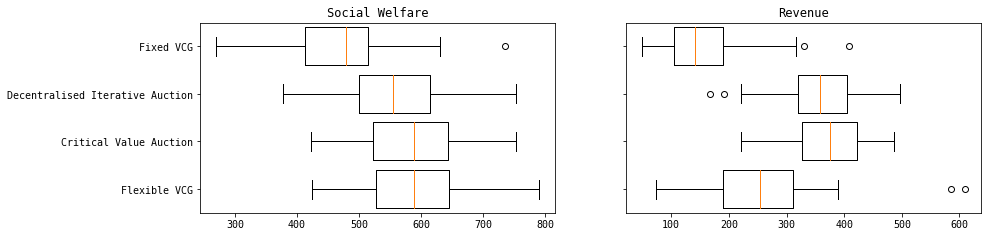

In [14]:
reduced_fig, (ax_reduced_sw, ax_reduced_rev) = plt.subplots(1, 2, figsize=(14, 3.5))
ax_reduced_sw.boxplot(reduced_df['social welfare'], vert=False, widths=0.8)
ax_reduced_sw.set_yticklabels(reduced_df['name'])
ax_reduced_sw.set_title('Social Welfare')
ax_reduced_rev.boxplot(reduced_df['revenue'], vert=False, widths=0.8)
plt.setp(ax_reduced_rev.get_yticklabels(), visible=False)
ax_reduced_rev.set_title('Revenue')
save_plot('auctions_results', 'auctions')

## Multi setting overall results

In [15]:
critical_value_auction = 'Critical Value Auction Utility * deadline / Sqrt Sum, Product, Pow percent sum'

def collect_data(filename, col, ax, with_optimal=True):
    with open(filename) as file:
        results_data = json.load(file)
        
        data = [[], [], [], []]
        for model_results in results_data:
            if with_optimal and model_results[critical_value_auction]['social welfare'] <= model_results['Flexible VCG']['social welfare']:
                data[0].append(model_results['Fixed VCG'][col])
                data[1].append(model_results['Flexible VCG'][col])
            data[2].append(model_results['Optimal DIA'][col])
            data[3].append(model_results[critical_value_auction][col])
    
        ax.boxplot(data, vert=False, widths=0.9)

Save file location: figs/auctions/eps/multi_setting_social_welfare.eps
Save file location: figs/auctions/png/multi_setting_social_welfare.png
Save file location: figs/auctions/pdf/multi_setting_social_welfare.pdf


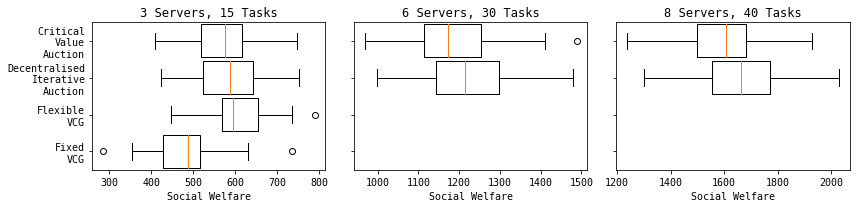

In [21]:
fig, (sw_t15_s3_ax, sw_t30_s6_ax, sw_t40_s8_ax) = plt.subplots(1, 3, figsize=(12, 3))
collect_data(f'{folder}/auctions_paper_r_t15_s3_dt07-22_11-55-31.json', 'social welfare', sw_t15_s3_ax)
sw_t15_s3_ax.set_yticklabels(['Fixed\nVCG', 'Flexible\nVCG', 'Decentralised\nIterative\nAuction', 'Critical\nValue\nAuction'])
sw_t15_s3_ax.set_title('3 Servers, 15 Tasks')
sw_t15_s3_ax.set_xlabel('Social Welfare')
collect_data(f'{folder}/auctions_paper_r_t30_s6_dt07-28_23-48-03.json', 'social welfare', sw_t30_s6_ax, with_optimal=False)
sw_t30_s6_ax.set_yticklabels(['', '', '', ''])
sw_t30_s6_ax.set_title('6 Servers, 30 Tasks')
sw_t30_s6_ax.set_xlabel('Social Welfare')
collect_data(f'{folder}/auctions_paper_r_t40_s8_dt07-22_11-57-21.json', 'social welfare', sw_t40_s8_ax, with_optimal=False)
sw_t40_s8_ax.set_yticklabels(['', '', '', ''])
sw_t40_s8_ax.set_title('8 Servers, 40 Tasks')
sw_t40_s8_ax.set_xlabel('Social Welfare')
fig.tight_layout()
save_plot('multi_setting_social_welfare', 'auctions')

Save file location: figs/auctions/eps/multi_setting_revenue.eps
Save file location: figs/auctions/png/multi_setting_revenue.png
Save file location: figs/auctions/pdf/multi_setting_revenue.pdf


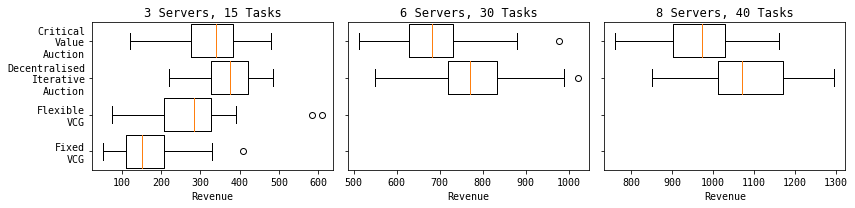

In [22]:
fig, (rev_t15_s3_ax, rev_t30_s6_ax, rev_t40_s8_ax) = plt.subplots(1, 3, figsize=(12, 3))
collect_data(f'{folder}/auctions_paper_r_t15_s3_dt07-22_11-55-31.json', 'total revenue', rev_t15_s3_ax)
rev_t15_s3_ax.set_yticklabels(['Fixed\nVCG', 'Flexible\nVCG', 'Decentralised\nIterative\nAuction', 'Critical\nValue\nAuction'])
rev_t15_s3_ax.set_title('3 Servers, 15 Tasks')
rev_t15_s3_ax.set_xlabel('Revenue')
collect_data(f'{folder}/auctions_paper_r_t30_s6_dt07-28_23-48-03.json', 'total revenue', rev_t30_s6_ax, with_optimal=False)
rev_t30_s6_ax.set_yticklabels(['', '', '', ''])
rev_t30_s6_ax.set_title('6 Servers, 30 Tasks')
rev_t30_s6_ax.set_xlabel('Revenue')
collect_data(f'{folder}/auctions_paper_r_t40_s8_dt07-22_11-57-21.json', 'total revenue', rev_t40_s8_ax, with_optimal=False)
rev_t40_s8_ax.set_yticklabels(['', '', '', ''])
rev_t40_s8_ax.set_title('8 Servers, 40 Tasks')
rev_t40_s8_ax.set_xlabel('Revenue')
fig.tight_layout()
save_plot('multi_setting_revenue', 'auctions')

### Normalised results

In [19]:
def percentage_difference(filename, algo_1, algo_2, col='social welfare', is_optimal=True):
    with open(filename) as file:
        results_data = json.load(file)
        
        return round(np.mean([result[algo_1][col] / result[algo_2][col] 
                        for result in results_data]), 3)
# or result[greedy_name]['social welfare'] <= result['Flexible Optimal']['social welfare']]

In [20]:
t15_s3 = f'{folder}/auctions_paper_r_t15_s3_dt07-22_11-55-31.json'
t30_s6 = f'{folder}/auctions_paper_r_t30_s6_dt07-28_23-48-03.json'
t40_s8 = f'{folder}/auctions_paper_r_t40_s8_dt07-22_11-57-21.json'

print(f'Percentage difference in social welfare and revenue')
print(f'Fixed / Flexible: {percentage_difference(t15_s3, "Fixed VCG", "Flexible VCG")}, '
      f'{percentage_difference(t30_s6, "Fixed VCG", "Flexible VCG")}')
print(f'Fixed / Flexible revenue: {percentage_difference(t15_s3, "Fixed VCG", "Flexible VCG", "total revenue")}, '
      f'{percentage_difference(t30_s6, "Fixed VCG", "Flexible VCG", "total revenue")}')
print(f'CVA / DIA: {percentage_difference(t15_s3, critical_value_auction, "Optimal DIA")}, '
      f'{percentage_difference(t30_s6, critical_value_auction, "Optimal DIA")}, '
      f'{percentage_difference(t40_s8, critical_value_auction, "Optimal DIA")}')
print(f'CVA / DIA revenue: {percentage_difference(t15_s3, critical_value_auction, "Optimal DIA", "total revenue")}, '
      f'{percentage_difference(t30_s6, critical_value_auction, "Optimal DIA", "total revenue")}, '
      f'{percentage_difference(t40_s8, critical_value_auction, "Optimal DIA", "total revenue")}')

Percentage difference in social welfare and revenue
Fixed / Flexible: 0.783, 0.812
Fixed / Flexible revenue: 0.639, 0.496
CVA / DIA: 0.981, 0.971, 0.965
CVA / DIA revenue: 0.881, 0.882, 0.899
